In [1]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$CUDNN_PATH/lib:$CONDA_PREFIX/lib/:$LD_LIBRARY_PATH
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

In [2]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

def get_datasets(num_epochs, batch_size):
    """Load MNIST train and test datasets into memory."""
    train_ds = tfds.load('mnist', split='train')
    test_ds = tfds.load('mnist', split='test')

    train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                            tf.float32) / 255.,
                                            'label': sample['label']}) # normalize train set
    test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                            tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

    train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
    test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

    return train_ds, test_ds

2023-12-12 10:18:50.506890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 10:18:50.539170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 10:18:50.539196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 10:18:50.540035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 10:18:50.545188: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from flax import linen as nn  # Linen API

class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [4]:
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   compute_flops=True, compute_vjp_flops=True))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs   ┃ flops   ┃ vjp_flops ┃ params     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│         │ CNN    │ float32[1… │ float32[… │ 8708106 │ 26957556  │            │
├─────────┼────────┼────────────┼───────────┼─────────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[1… │ float32[… │ 455424  │ 1341472   │ bias:      │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │ kernel:    │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │            │
│         │        │            │           │         │           │ 320 (1.3   │
│         │        │       

In [6]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

In [7]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [14]:
class TrainState(train_state.TrainState):
    metrics: Metrics

In [8]:
def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [9]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [10]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [11]:
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

2023-12-12 10:22:04.308732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 348 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6


In [12]:
tf.random.set_seed(0)
init_rng = jax.random.key(0)

In [15]:
learning_rate = 0.01
momentum = 0.9
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [16]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [17]:
for step, batch in enumerate(train_ds.as_numpy_iterator()):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

    if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        for test_batch in test_ds.as_numpy_iterator():
            test_state = compute_metrics(state=test_state, batch=test_batch)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.20352981984615326, accuracy: 93.82167053222656
test epoch: 1, loss: 0.08746376633644104, accuracy: 97.14543151855469
train epoch: 2, loss: 0.05837944895029068, accuracy: 98.25833129882812
test epoch: 2, loss: 0.053458813577890396, accuracy: 98.29727172851562
train epoch: 3, loss: 0.03811197727918625, accuracy: 98.91000366210938
test epoch: 3, loss: 0.043692223727703094, accuracy: 98.67788696289062
train epoch: 4, loss: 0.028012890368700027, accuracy: 99.16333770751953
test epoch: 4, loss: 0.04673873260617256, accuracy: 98.40745544433594
train epoch: 5, loss: 0.02217952534556389, accuracy: 99.37333679199219
test epoch: 5, loss: 0.033743374049663544, accuracy: 98.95833587646484
train epoch: 6, loss: 0.0169532373547554, accuracy: 99.52000427246094
test epoch: 6, loss: 0.034845009446144104, accuracy: 98.92828369140625
train epoch: 7, loss: 0.0136748431250453, accuracy: 99.64167022705078
test epoch: 7, loss: 0.03191753104329109, accuracy: 99.00841522216797
train epoc

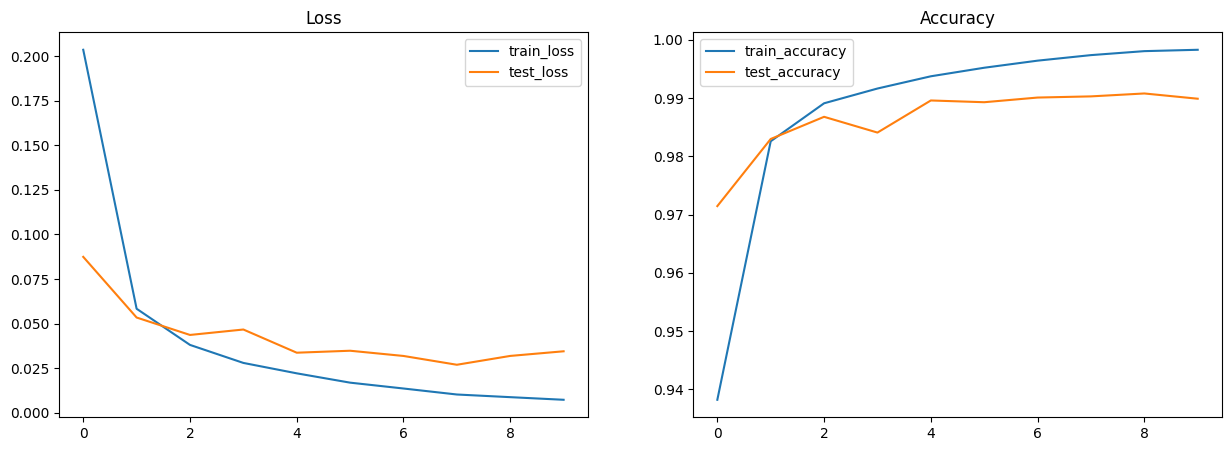

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [19]:
@jax.jit
def pred_step(state, batch):
    logits = state.apply_fn({'params': state.params}, test_batch['image'])
    return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

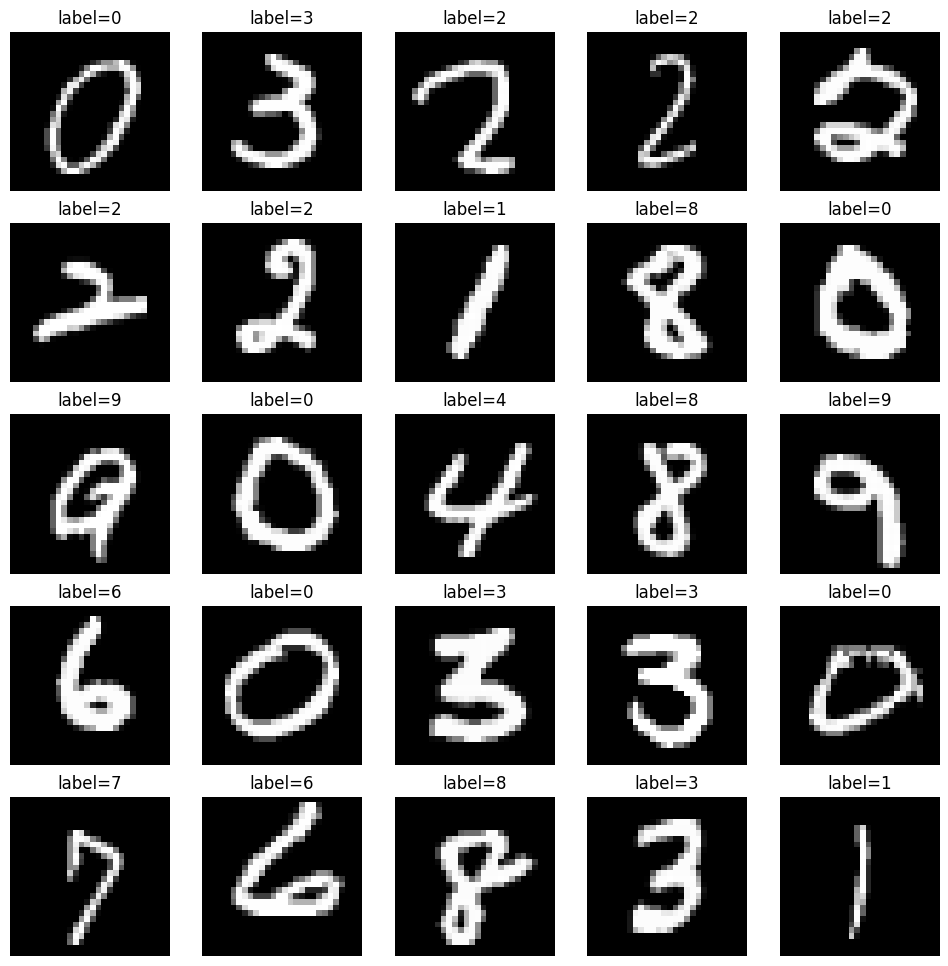

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')